#### BARRY ALPHA & VIANNEY GRIMAUD

In [1]:
import pandas as pd
import functools
from river import datasets
from river import ensemble
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import neighbors
from river import utils
from sklearn.preprocessing import StandardScaler
from river.tree import HoeffdingAdaptiveTreeClassifier
from river.linear_model import LogisticRegression
from river.metrics import Accuracy, F1
from river.neighbors import KNNClassifier
from river.stream import iter_pandas

In [2]:
dataset = datasets.Elec2()

In [3]:
file_path = '/Users/barryalphaoumar/river_data/Elec2/electricity.csv'
df = pd.read_csv(file_path)

In [4]:
df['class'] = df['class'].map({'UP': 1, 'DOWN': 0})

In [5]:
X = df.drop('class', axis=1)  # features
y = df['class']  # target variable

In [6]:
def print_progress(sample_id, accuracy, f1):
    print(f'Samples processed: {sample_id}')
    print(accuracy)
    print(f1)


def evaluate(stream, model, n_wait=1000, verbose=False):
    accuracy = metrics.Accuracy()
    f1 = metrics.F1()
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        accuracy.update(y_true=y, y_pred=y_pred)
        f1.update(y_true=y, y_pred=y_pred)
        
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, accuracy, f1)
            raw_results.append([model_name, i, accuracy.get(), f1.get()])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, accuracy, f1)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'Accuracy', 'F1'])


In [7]:
ht = HoeffdingAdaptiveTreeClassifier(
    grace_period=100,
    delta=1e-5,
    leaf_prediction='nb',
    nb_threshold=10,
    seed=0
)

l1_dist = functools.partial(utils.math.minkowski_distance, p=1)
knn=(
    preprocessing.StandardScaler() |
    neighbors.KNNClassifier(
        engine=neighbors.SWINN(
            dist_func=l1_dist,
            seed=42
        )
    )
)


lr=(
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(optimizer=optim.SGD(.1))
)



lbc=ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |
        linear_model.LogisticRegression()
    ),
    n_models=3,
    seed=42
)

In [8]:
ht_results = evaluate(stream=iter_pandas(X=X, y=y),
                      model=ht)

Samples processed: 45311
Accuracy: 82.37%
F1: 79.02%


In [9]:
knn_results = evaluate(stream=iter_pandas(X=X, y=y),
                      model=knn)

Samples processed: 45311
Accuracy: 86.16%
F1: 83.36%


In [10]:
lr_results = evaluate(stream=iter_pandas(X=X, y=y),
                      model=lr)

Samples processed: 45311
Accuracy: 89.49%
F1: 87.48%


In [11]:
lbc_results=evaluate(stream=iter_pandas(X=X, y=y),
                      model=lbc)

Samples processed: 45311
Accuracy: 87.63%
F1: 85.06%


In [13]:
knn_results["model"] = "KNN Classifier"
lr_results["model"] = "Logistic Regression"
lbc_results["model"] = "Leveraging Bagging Classifier"

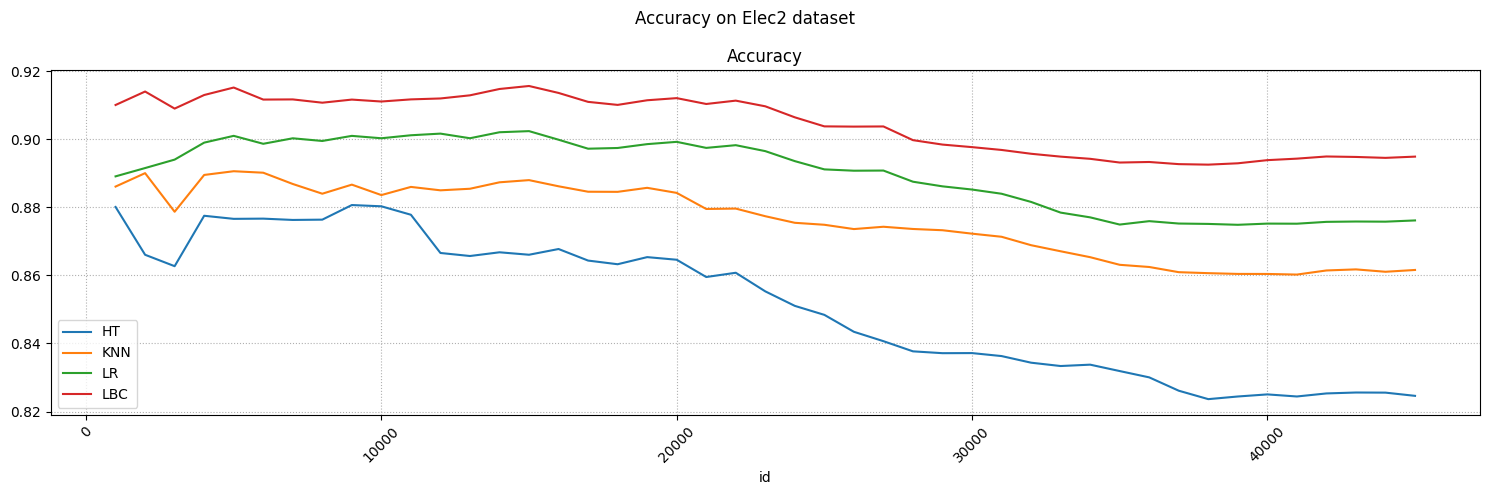

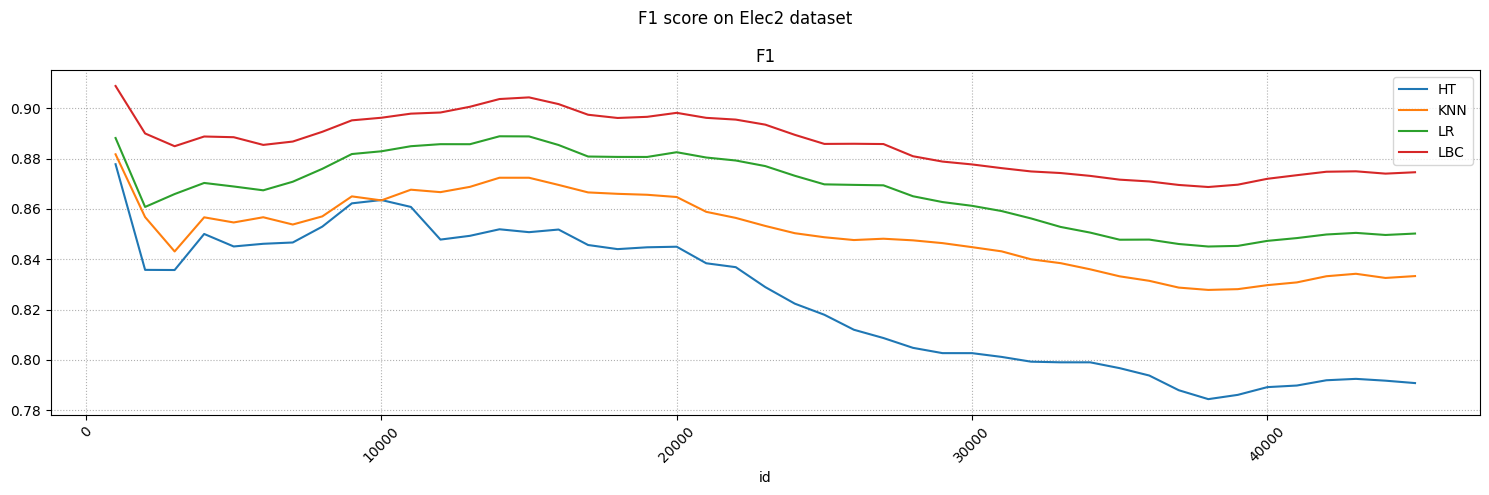

In [14]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pd.concat([ht_results, knn_results, lr_results,lbc_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')
dataset='Elec2'

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) 
    grouped['Accuracy'].plot(rot=45, title='Accuracy', legend=True, ax=ax)
    ax.legend(["HT", "KNN", "LR","LBC"], loc='best')
    ax.grid(linestyle=':')
    fig.suptitle(f"Accuracy on {dataset} dataset")
    plt.tight_layout()
    pdf.savefig()  

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    grouped['F1'].plot(rot=45, title='F1', legend=True, ax=ax)
    ax.legend(["HT", "KNN", "LR","LBC"], loc='best')
    ax.grid(linestyle=':')
    fig.suptitle(f"F1 score on {dataset} dataset")
    plt.tight_layout()
    pdf.savefig() 